In [12]:
import os
import sys
import grid2op
res = None
try:
    from jyquickhelper import add_notebook_menu
    res = add_notebook_menu()
except ModuleNotFoundError:
    print("Impossible to automatically add a menu / table of content to this notebook.\nYou can download \"jyquickhelper\" package with: \n\"pip install jyquickhelper\"")
res

In [2]:
#action里有两个概念，change和set，change用于改变状态(如连接变成断开)，set用于设定状态(如连接，不管之前是什么状态)
#有些action是模糊的(例如连接一条不存在的powerline)，这时的action会被设定成do nothing
#每个agent都有自己的action space属性，称为self.action_space。
#这里采用TopologyAction：更改powerline的状态(连接或断开)，或更改主体连接变电站的方式(bus1还是2)。
from grid2op.PlotGrid import PlotMatplot
env = grid2op.make(test=True)
action_space = env.action_space
do_nothing = action_space({})
do_nothing

D:\virtualenvironment\L2PRN_grid2op\lib\site-packages\grid2op\MakeEnv\Make.py:265: UserWarning: You are using a development environment. This environment is not intended for training agents. It might not be up to date and its primary use if for tests (hence the "test=True" you passed as argument). Use at your own risk.
  warnings.warn(_MAKE_DEV_ENV_WARN)


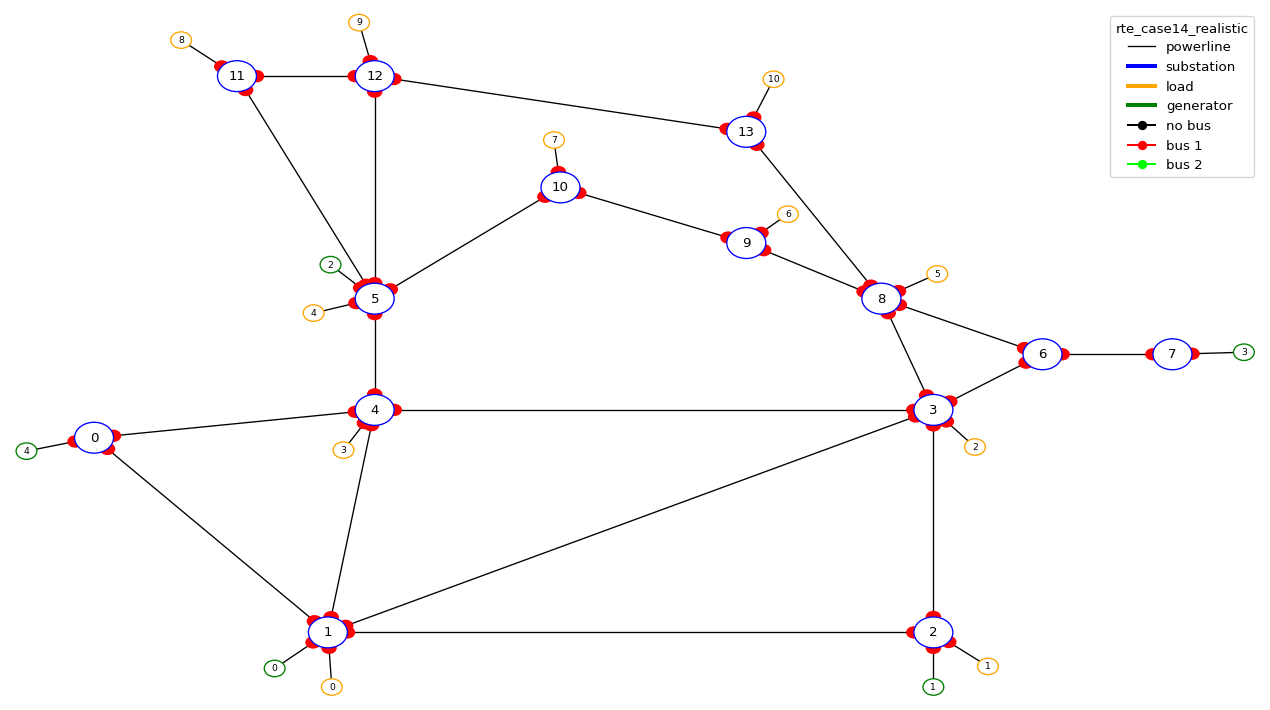

In [3]:
#画拓扑
plot_helper = PlotMatplot(env.observation_space)
_=plot_helper.plot_layout()

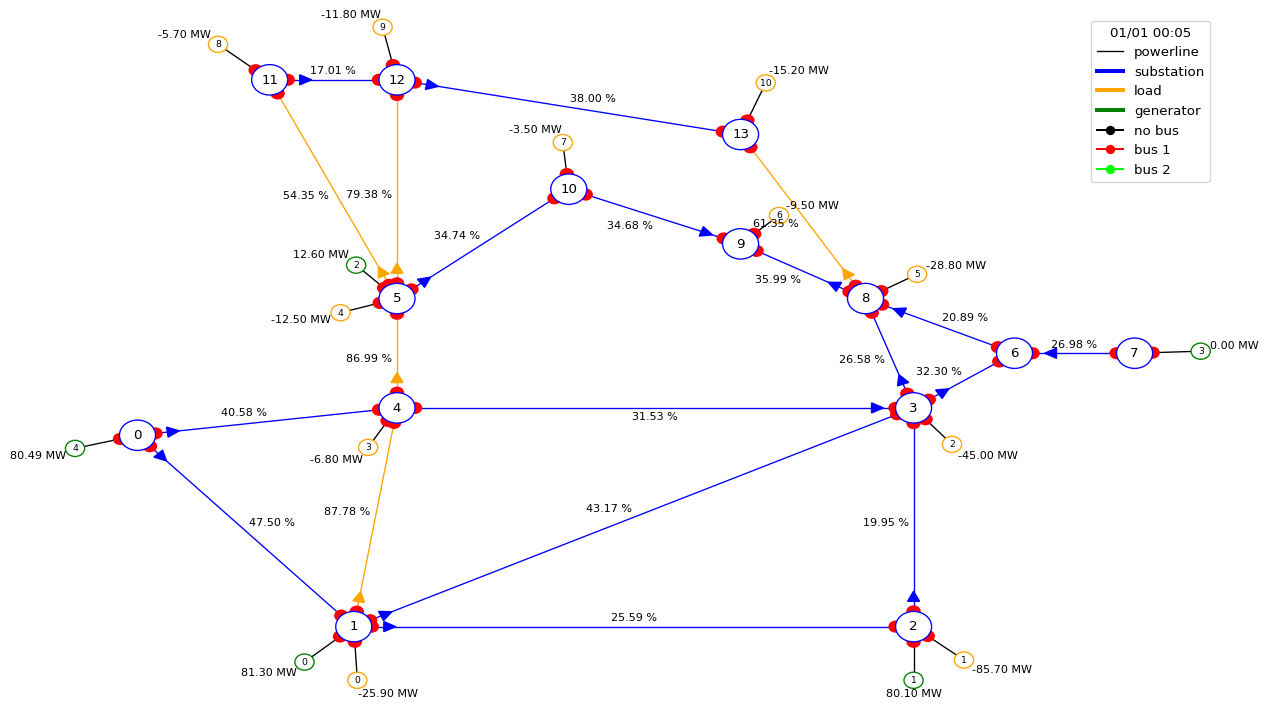

In [10]:
#画状态
obs_before = env.reset()
_=plot_helper.plot_obs(obs_before)

In [5]:
#action：change powerline 0,1,2的状态,set powerline 3,4的状态为connected，set powerline 5,6的状态为disconnected
#change: True代表change,False代表don't change。set:0是do nothing，1是connct it，2是disconnect it
change_status = action_space.get_change_line_status_vect()
change_status[0] = True
change_status[1] = True
change_status[2] = True

set_status = action_space.get_set_line_status_vect()
set_status[3] = 1
set_status[4] = 1
set_status[5] = -1
set_status[6] = -1

this_first_act = action_space({"set_line_status":set_status,"change_line_status":change_status})
print(this_first_act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 2 powerlines ([3 4])
	 - force disconnection of 2 powerlines ([5 6])
	 - switch status of 3 powerlines ([0 1 2])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


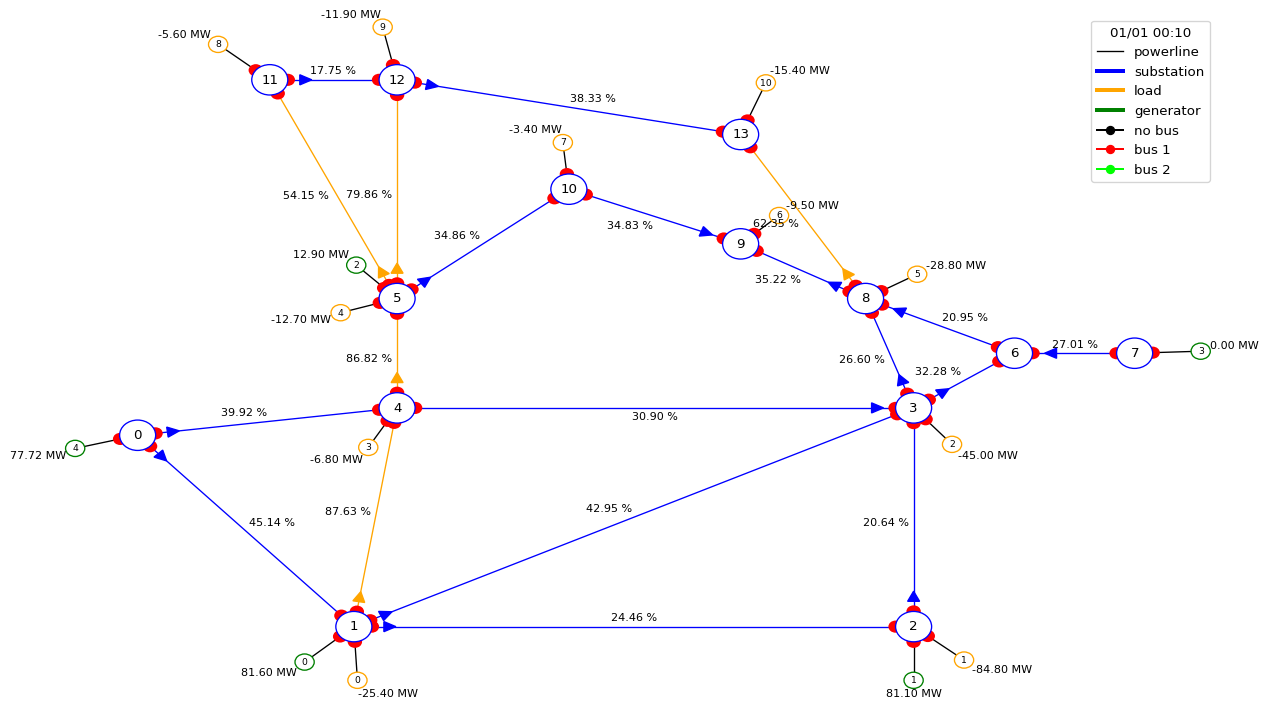

In [6]:
obs_after, reward, done, info = env.step(this_first_act)
_ = plot_helper.plot_obs(obs_after)

In [7]:
this_first_act.is_ambiguous()
print(this_first_act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 2 powerlines ([3 4])
	 - force disconnection of 2 powerlines ([5 6])
	 - switch status of 3 powerlines ([0 1 2])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


In [8]:
the_same_act = action_space({"set_line_status":[(3,1),(4,1),(5,-1),(6,-1)],"change_line_status":[0,1,2]})
print(the_same_act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 2 powerlines ([3 4])
	 - force disconnection of 2 powerlines ([5 6])
	 - switch status of 3 powerlines ([0 1 2])
	 - NOT switch anything in the topology
	 - NOT force any particular bus configuration


In [19]:
the_same_act == this_first_act

True

In [21]:
#这部分是修改powergrid的拓扑，就是修改objects连接到的substation的bus。
#例如set负载连接的bus
set_bus_load_0 = action_space({"set_bus":{"loads_id":[(0,2)]}})
print(set_bus_load_0)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to load 0 [on substation 1]


In [9]:
#change负载连接的bus
change_bus_load_0 = action_space({"change_bus":{"loads_id":[0]}})
print(change_bus_load_0)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - Change the bus of the following element:
	 	 - switch bus of load 0 [on substation 1]
	 - NOT force any particular bus configuration


In [23]:
#发电机的change和set于负载类似
change_bus_gen_0_and_1 = action_space({"change_bus":{"generators_id":[0,1]}})
set_bus_gen_3_and_4 = action_space({"set_bus":{"generators_id":[(3,2),(4,2)]}})
print(set_bus_gen_3_and_4)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to generator 4 [on substation 0]
	 	 - assign bus 2 to generator 3 [on substation 7]


In [24]:
#powerline有两个端，origin和extremity
change_bus_lines_or_0 = action_space({"change_bus": {"lines_or_id": [0]}})
set_bus_lines_or_4 = action_space({"set_bus": {"lines_or_id": [(3,2)]}})
change_bus_lines_ex_15 = action_space({"change_bus": {"lines_ex_id": [15]}})
set_bus_lines_ex_18 = action_space({"set_bus": {"lines_ex_id": [(18,2)]}})
print(set_bus_lines_ex_18)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (extremity) 18 [on substation 7]


In [5]:
#reconnecting pwerline
reconnecting_line_1 = action_space.reconnect_powerline(line_id=1,bus_or=1,bus_ex=1)
print(reconnecting_line_1)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - force reconnection of 1 powerlines ([1])
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 1 to line (origin) 1 [on substation 0]
	 	 - assign bus 1 to line (extremity) 1 [on substation 4]


In [10]:
#如果预先知道一个变电站中的所有设备，也可以用下面代码来设置配置bus，如下面是将设备id为1,2,5(第2,3,6)连接到bus2，其他连接到bus1
reconfigure_substation_id_1 = action_space({"set_bus":{"substations_id":[(1,(1,2,2,1,1,2))]}})
print(reconfigure_substation_id_1)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 1 to line (extremity) 0 [on substation 1]
	 	 - assign bus 2 to line (origin) 2 [on substation 1]
	 	 - assign bus 2 to line (origin) 3 [on substation 1]
	 	 - assign bus 1 to line (origin) 4 [on substation 1]
	 	 - assign bus 1 to generator 0 [on substation 1]
	 	 - assign bus 2 to load 0 [on substation 1]


In [17]:
#要实现上述action，必须知道所有对象的id，可以通过grid_objects_types,其是一个五列的数组，每列分别是substation id,load id,generator id
#powerline origin id,powerline extremity id.-1表示没有连接
#例如第12行表示substation 2连接着id为1的负载，其他无连接。
action_space.grid_objects_types[12]

array([ 2,  1, -1, -1, -1])

In [20]:
#查看设备所处的位置
is_load = action_space.grid_objects_types[:,action_space.LOA_COL] != -1
print("The substation with at least one load are: {}".format(action_space.grid_objects_types[is_load,action_space.SUB_COL]))

is_sub1 = action_space.grid_objects_types[:, action_space.SUB_COL] == 1
is_gen = action_space.grid_objects_types[:, action_space.GEN_COL] != -1
print("The generator ids connected to substations 1 are: {}".format(action_space.grid_objects_types[is_sub1 & is_gen, action_space.GEN_COL]))
print("The object connected to substation 1 are: {}".format(action_space.grid_objects_types[is_sub1,:]))

The substation with at least one load are: [ 1  2  3  4  5  8  9 10 11 12 13]
The generator ids connected to substations 1 are: [0]
The object connected to substation 1 are: [[ 1 -1 -1 -1  0]
 [ 1 -1 -1  2 -1]
 [ 1 -1 -1  3 -1]
 [ 1 -1 -1  4 -1]
 [ 1 -1  0 -1 -1]
 [ 1  0 -1 -1 -1]]


In [21]:
#get_obj_connect_to更清晰，下面语句说明，substation 1连接了：id为0的load，id为0的generator，id为2,3,4的powerline origin，
#id为0的powerline extremity
#该substation连接了6个元素
action_space.get_obj_connect_to(substation_id=1)

{'loads_id': array([0], dtype=int64),
 'generators_id': array([0], dtype=int64),
 'lines_or_id': array([2, 3, 4], dtype=int64),
 'lines_ex_id': array([0], dtype=int64),
 'nb_elements': 6}

In [11]:
#另外一种更方便的更改bus的方式是用设备的名字，而不是id
my_act = action_space.set_bus("gen_1_0", # 设备名字和id
                               new_bus=2, # bus2
                               type_element="gen", # 设备类型，"line", "gen" or "load"
                               previous_action=None  # 可选项: 可以参与多个action
                              )
print(my_act)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to generator 0 [on substation 1]


In [34]:
my_act_2 = action_space.set_bus("1_3_3", # line 3
                     extremity="or", # origin端
                     new_bus=2, # bus 2
                     type_element="line", 
                     previous_action=my_act  # 采取my act动作
                    )
print(my_act_2)

This action will:
	 - NOT change anything to the injections
	 - NOT perform any redispatching action
	 - NOT force any line status
	 - NOT switch any line status
	 - NOT switch anything in the topology
	 - Set the bus of the following element:
	 	 - assign bus 2 to line (origin) 3 [on substation 1]
	 	 - assign bus 2 to generator 0 [on substation 1]
